In [1]:
import pandas, numpy
import matplotlib.pyplot as plt 
import seaborn as sns

In [2]:
applications = pandas.read_csv("./application_record.csv")
credit_records = pandas.read_csv("./credit_record.csv")

In [3]:
# Let's take a look at each dataset individually 
applications.head(10)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
5,5008810,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
6,5008811,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
7,5008812,F,N,Y,0,283500.0,Pensioner,Higher education,Separated,House / apartment,-22464,365243,1,0,0,0,NaN,1.0
8,5008813,F,N,Y,0,283500.0,Pensioner,Higher education,Separated,House / apartment,-22464,365243,1,0,0,0,NaN,1.0
9,5008814,F,N,Y,0,283500.0,Pensioner,Higher education,Separated,House / apartment,-22464,365243,1,0,0,0,NaN,1.0


In [4]:
# Lets' see how the credit record looks like 
# 1 - due less 30 days
# 2 - due 30 - 60 days 
# 3 - due 60 - 90 days
# 4 - due 90 - 150 days 
# 5 - due over 150 days 

credit_records.head(10)

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C
5,5001712,-1,C
6,5001712,-2,C
7,5001712,-3,C
8,5001712,-4,C
9,5001712,-5,C


In [5]:
# Relabling Credit Records Dataset

CREDIT_MAPPING = {
    "ID": "client_id",
    "STATUS": "due_status",
    "MONTHS_BALANCE": "balance_month"
}
credit_records.rename(columns=CREDIT_MAPPING, inplace=True)

# Relabling Applications Records Dataset
APPLICATION_MAPPING = {
    "ID": "client_id",
    "CODE_GENDER": "gender",
    "FLAG_OWN_CAR": "has_car",
    "FLAG_OWN_REALTY": "has_realty",
    "CNT_CHILDREN": "total_children",
    "AMT_INCOME_TOTAL": "annual_income",
    "NAME_INCOME_TYPE": "income_category",
    "NAME_EDUCATION_TYPE": "education_category",
    "NAME_FAMILY_STATUS": "family_status",
    "NAME_HOUSING_TYPE": "living_place",
    "DAYS_BIRTH": "birthday",
    "FLAG_MOBIL": "has_mobile_phone",
    "FLAG_PHONE": "has_phone",
    "FLAG_WORK_PHONE": "has_work_phone",
    "FLAG_EMAIL": "has_email",
    "CNT_FAM_MEMBERS": "family_size",
    "OCCUPATION_TYPE": "job",
    'DAYS_EMPLOYED': 'days_employed',
}

applications.rename(columns=APPLICATION_MAPPING, inplace=True)

In [6]:
# Editing Dataset Labels for better understanding and easier usage 
applications.info()
applications.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   client_id           438557 non-null  int64  
 1   gender              438557 non-null  object 
 2   has_car             438557 non-null  object 
 3   has_realty          438557 non-null  object 
 4   total_children      438557 non-null  int64  
 5   annual_income       438557 non-null  float64
 6   income_category     438557 non-null  object 
 7   education_category  438557 non-null  object 
 8   family_status       438557 non-null  object 
 9   living_place        438557 non-null  object 
 10  birthday            438557 non-null  int64  
 11  days_employed       438557 non-null  int64  
 12  has_mobile_phone    438557 non-null  int64  
 13  has_work_phone      438557 non-null  int64  
 14  has_phone           438557 non-null  int64  
 15  has_email           438557 non-nul

client_id                  0
gender                     0
has_car                    0
has_realty                 0
total_children             0
annual_income              0
income_category            0
education_category         0
family_status              0
living_place               0
birthday                   0
days_employed              0
has_mobile_phone           0
has_work_phone             0
has_phone                  0
has_email                  0
job                   134203
family_size                0
dtype: int64

In [7]:
# Let's see how many nan values we have in credit records dataset
credit_records.info() 
credit_records.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   client_id      1048575 non-null  int64 
 1   balance_month  1048575 non-null  int64 
 2   due_status     1048575 non-null  object
dtypes: int64(2), object(1)
memory usage: 24.0+ MB


client_id        0
balance_month    0
due_status       0
dtype: int64

In [8]:
# Let's see how many unique application records we have
applications['client_id'].nunique()

438510

In [9]:
# Let's see how many unique credit record we have
credit_records["client_id"].nunique()

45985

In [10]:
# let's see how many intersections to we have 
applications.merge(credit_records, on="client_id")["client_id"].nunique()

36457

In [11]:
# Calculating credit window for each individual customer 

grouped = credit_records.groupby('client_id')
customer_credit = pandas.DataFrame()

customer_credit['open_month'] = grouped['balance_month'].min() # smallest value of MONTHS_BALANCE, is the month when loan was granted
customer_credit['end_month'] = grouped['balance_month'].max() # biggest value of MONTHS_BALANCE, might be observe over or canceling account

customer_credit["credit_window"] = customer_credit["end_month"] - customer_credit["open_month"] + 1
customer_credit.reset_index(inplace=True)

customer_credit = customer_credit[['client_id', 'credit_window']]



In [12]:
# Joining with main credit table and finding credit difference
print(credit_records)

DUE_DATATYPES = {
    "0": 0,
    "1": 0,
    "2": 1,
    "3": 1,
    "4": 1,
    "5": 1,
    "X": 0,
    "C": 0
}

def convert_due_status(status: str):
    """
    Transforms digit due statuses to meaningful names
    everything, that is higher than 1 marks as 'overdue', which indicates, 
    that client had a huge pay out delay and might be not reliable
    """
    if not isinstance(status, str): return 0

    if status.isdigit():
        if int(status) > 1: 
            return 1 
    return 0

# Mapping values according to specified standards

credit_records["due_status"] = credit_records['due_status'].map(lambda item: DUE_DATATYPES[str(item)])

print(credit_records['due_status'])

# Overdue metrics per client
overdue_per_client = credit_records[["client_id", "due_status"]].groupby(
by=["client_id"])['due_status'].sum().to_frame('overdue_frequency').reset_index()

customer_credit = customer_credit.merge(overdue_per_client, on='client_id', how='inner')

customer_credit["bad_client"] = overdue_per_client["overdue_frequency"].apply(
func=lambda item: True if item > 0 else False)

customer_credit = customer_credit[["client_id", "credit_window", "bad_client"]]

def set_datatypes(dataset: pandas.DataFrame):
    """
    Optimizing datatypes for dataset compression
    """
    dataset["client_id"] = dataset["client_id"].astype(numpy.int64)
    dataset["credit_window"] = dataset["credit_window"].astype(numpy.int16)
    return dataset

completed_feature_dataset = set_datatypes(customer_credit)

# After Optimizing our dataset, let's check it's characteristics 

completed_feature_dataset.info()

         client_id  balance_month due_status
0          5001711              0          X
1          5001711             -1          0
2          5001711             -2          0
3          5001711             -3          0
4          5001712              0          C
...            ...            ...        ...
1048570    5150487            -25          C
1048571    5150487            -26          C
1048572    5150487            -27          C
1048573    5150487            -28          C
1048574    5150487            -29          C

[1048575 rows x 3 columns]
0          0
1          0
2          0
3          0
4          0
          ..
1048570    0
1048571    0
1048572    0
1048573    0
1048574    0
Name: due_status, Length: 1048575, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45985 entries, 0 to 45984
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   client_id      45985 non-null  int64
 1   cr

In [13]:
# merging with main application records using left join (we want to keep customer's which does not have any )

Text(0.5, 0, 'Proportion of good and bad customers. Bad - 1; Good - 0')

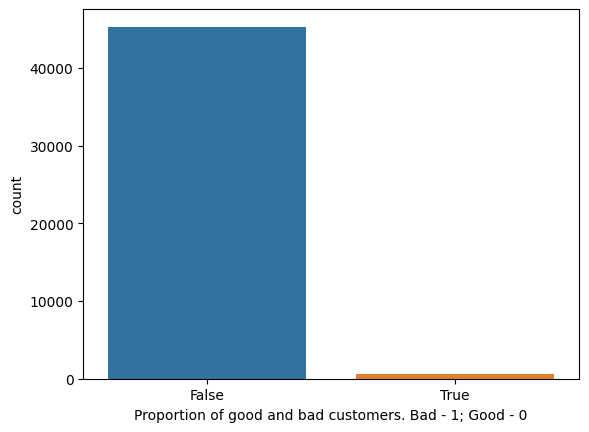

In [14]:
# Let's see how many clients are good (can be potentially considered by the banks) and bad clients

sns.countplot(data=completed_feature_dataset, x="bad_client")
plt.xlabel("Proportion of good and bad customers. Bad - 1; Good - 0")

In [15]:
# Let's investigate majority class to get more information about it 

data = completed_feature_dataset

In [16]:
# let's try different techniques for managing imbalanced datasets

In [17]:
# Sampling Techniques for dealing with imbalanced datasets
import typing, logging
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import precision_score
import pandas 
import constants 

Logger = logging.getLogger(__name__)

def rose_over_sampling(
    X_train: typing.Union[pandas.DataFrame, pandas.Series],
    Y_train: pandas.Series
):
    if not len(X_train) or not len(Y_train): return None, None
    try:
        sampler  = RandomOverSampler(random_state=1)
        X_resampled, Y_resampled = sampler.fit_resample(X=X_train, y=Y_train)
        return X_resampled, Y_resampled 
    except(TypeError, ValueError) as sampling_exception:
        Logger.debug("Failed to perform ROSE Over Sampling Technique, Exception Arised. [%s]"
        % sampling_exception)
        return None, None

def rose_under_sampling(X_train: pandas.DataFrame, Y_train: pandas.Series):
    if not len(X_train) or not len(Y_train): return None, None
    try:
        sampler = RandomUnderSampler(random_state=1)
        X_resampled, Y_resampled = sampler.fit_resample(X=X_train, y=Y_train)
        return X_resampled, Y_resampled 
    except(TypeError, ValueError) as sampling_exception:
        Logger.debug("Failed to perform ROSE Under Sampling Technique, Exception Arised. [%s]"
        % sampling_exception)
        return None, None
    

def smote_sampling(
    X_train: typing.Union[pandas.DataFrame, pandas.Series], 
    Y_train: typing.Union[pandas.DataFrame, pandas.Series]):

    if not len(X_train) or not len(Y_train): return None, None 
    try:
        smote_tech = SMOTE(random_state=1, k_neighbors=constants.K_SMOTE_NEIGHBORS)
        X_resampled, Y_resampled = smote_tech.fit_resample(X_train, Y_train)
        return X_resampled, Y_resampled
    except(TypeError, ValueError) as train_exception:
        Logger.debug("Failed to balance data using SMOTE Technique, exception raised. [%s]" % train_exception)
        return None, None 


In [18]:
# let's split data and try out SMOTE method on our data

X_data = data.drop(columns=["bad_client"])
Y_data = data["bad_client"]

from sklearn.model_selection import train_test_split 

# Splitting data on training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, random_state=1)

# Transforming each dataset individually 

SM_XR_sampled, SM_YR_sampled = smote_sampling(X_train, Y_train)

In [19]:
# Let's visualize new data
SM_YR_sampled.value_counts()

bad_client
False    33995
True     33995
Name: count, dtype: int64

<Axes: ylabel='count'>

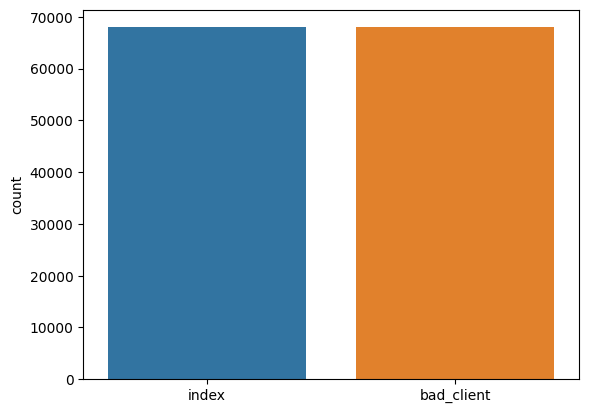

In [20]:
# Performing Feature Encodings to the dataset
sns.countplot(SM_YR_sampled.reset_index())

In [21]:
# Merging with application records feature dataset
credit_feature_dataset = pandas.concat([SM_XR_sampled, SM_YR_sampled], axis=1)

full_feature_dataset = credit_feature_dataset.merge(applications, on="client_id")

# Dropping duplicated rows
full_feature_dataset.drop_duplicates(inplace=True)

In [22]:
# Imputing missing values before encoding

full_feature_dataset.isna().sum()

client_id                 0
credit_window             0
bad_client                0
gender                    0
has_car                   0
has_realty                0
total_children            0
annual_income             0
income_category           0
education_category        0
family_status             0
living_place              0
birthday                  0
days_employed             0
has_mobile_phone          0
has_work_phone            0
has_phone                 0
has_email                 0
job                   13245
family_size               0
dtype: int64

In [23]:
# Using Mode Imputation for Nominal Categorical Feature 'Job'
MISSING_JOB = "missing_job"
full_feature_dataset['job'].fillna(MISSING_JOB, inplace=True)


In [24]:
# Checking the imputation status 
full_feature_dataset.isna().sum()

client_id             0
credit_window         0
bad_client            0
gender                0
has_car               0
has_realty            0
total_children        0
annual_income         0
income_category       0
education_category    0
family_status         0
living_place          0
birthday              0
days_employed         0
has_mobile_phone      0
has_work_phone        0
has_phone             0
has_email             0
job                   0
family_size           0
dtype: int64

In [25]:
# Encoding Binary Features

def encode_binary_features(dataset: pandas.DataFrame):
    # transforming binary features to numeric representation 
    binary_features = ["has_car", "has_mobile_phone", 
    "has_phone", "has_email", "has_work_phone", "has_realty"]
    for feature in binary_features:
        if feature in dataset.columns:
            dataset[feature] = dataset[feature].apply(func=(lambda item: True if item == "Y" else False))
    
def encode_gender_feature(dataset: pandas.DataFrame):
    # Encoding Gender Feature using One-Hot Encoding
    if 'gender' not in dataset.columns: return dataset
    gender_features = pandas.get_dummies(dataset['gender']).rename(
    columns={'F': 'Female', 'M': 'Male'})
    
    # concatinating table back
    dataset.drop(columns=['gender'], inplace=True)
    return pandas.concat([dataset, gender_features], axis=1)

    
encode_binary_features(full_feature_dataset)
feature_dataset = encode_gender_feature(full_feature_dataset)


feature_dataset.isna().sum()

client_id             0
credit_window         0
bad_client            0
has_car               0
has_realty            0
total_children        0
annual_income         0
income_category       0
education_category    0
family_status         0
living_place          0
birthday              0
days_employed         0
has_mobile_phone      0
has_work_phone        0
has_phone             0
has_email             0
job                   0
family_size           0
Female                0
Male                  0
dtype: int64

In [26]:
# Engineering features for application records 

import math 

feature_dataset['employed']  = feature_dataset['days_employed'].apply(func=lambda day: False if day > 0 else True)
feature_dataset['age'] = feature_dataset['birthday'].apply(func=lambda day: math.floor(abs(day) / 365))

feature_dataset.drop(columns=["days_employed", "birthday"], inplace=True)
feature_dataset.isna().sum()

client_id             0
credit_window         0
bad_client            0
has_car               0
has_realty            0
total_children        0
annual_income         0
income_category       0
education_category    0
family_status         0
living_place          0
has_mobile_phone      0
has_work_phone        0
has_phone             0
has_email             0
job                   0
family_size           0
Female                0
Male                  0
employed              0
age                   0
dtype: int64

In [27]:
# Standartizing Numeric Features 

numeric_set = feature_dataset.select_dtypes(include='number').columns
numeric_set = numeric_set[1:].tolist()

numeric_set

['credit_window', 'total_children', 'annual_income', 'family_size', 'age']

In [35]:
from sklearn.preprocessing import StandardScaler 

scaler = StandardScaler() 
scaled_data = pandas.DataFrame(scaler.fit_transform(feature_dataset[numeric_set]), 
columns=numeric_set)

feature_dataset.isna().sum()
scaled_data

,credit_window,total_children,annual_income,family_size,age
0,-1.285300,0.751318,-1.185710,0.866409,-0.276702
1,-0.827537,0.751318,-1.185710,0.866409,-0.276702
2,-1.416090,-0.567144,0.386122,-0.218912,-1.229664
3,-0.042799,0.751318,4.427975,0.866409,0.416362
4,1.134307,-0.567144,0.161574,-0.218912,0.416362
...,...,...,...,...,...
43098,-0.369773,0.751318,-0.736615,0.866409,-0.536601
43099,-0.762142,-0.567144,-0.242611,-1.304234,1.022793
43100,0.938122,-0.567144,-1.185710,-0.218912,0.849527
43101,1.199701,-0.567144,0.161574,-0.218912,1.282692


In [38]:
# Merging back to the main feature table 

feature_dataset[numeric_set] = scaled_data

feature_dataset.isna().sum()
feature_dataset

,client_id,credit_window,bad_client,has_car,has_realty,total_children,annual_income,income_category,education_category,family_status,...,has_mobile_phone,has_work_phone,has_phone,has_email,job,family_size,Female,Male,employed,age
0,5118635,-1.285300,False,False,False,0.751318,-1.185710,Commercial associate,Secondary / secondary special,Married,...,False,False,False,False,Core staff,0.866409,True,False,True,-0.276702
1,5118635,-0.827537,True,False,False,0.751318,-1.185710,Commercial associate,Secondary / secondary special,Married,...,False,False,False,False,Core staff,0.866409,True,False,True,-0.276702
3,5104890,-0.042799,False,True,True,0.751318,4.427975,Working,Higher education,Married,...,False,False,False,False,Laborers,0.866409,False,True,True,0.416362
4,5021719,1.134307,False,True,True,-0.567144,0.161574,Working,Secondary / secondary special,Married,...,False,False,False,False,missing_job,-0.218912,True,False,True,0.416362
5,5047926,0.284174,False,True,True,-0.567144,0.161574,Commercial associate,Secondary / secondary special,Married,...,False,False,False,False,Cooking staff,-0.218912,False,True,True,0.416362
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51632,5033774,NaN,True,False,True,NaN,NaN,Working,Secondary / secondary special,Married,...,False,False,False,False,missing_job,NaN,True,False,True,NaN
51633,5029141,NaN,True,False,True,NaN,NaN,Working,Secondary / secondary special,Single / not married,...,False,False,False,False,Cooking staff,NaN,True,False,True,NaN
51634,5145833,NaN,True,False,True,NaN,NaN,Working,Secondary / secondary special,Married,...,False,False,False,False,Core staff,NaN,True,False,True,NaN
51635,5041105,NaN,True,False,True,NaN,NaN,Pensioner,Secondary / secondary special,Married,...,False,False,False,False,missing_job,NaN,True,False,False,NaN
